Training Accuracy:  1.0000
Validation Accuracy: 1.0000
Test Accuracy:      1.0000

Cross-Validation Accuracies: [1.      1.      0.99375 1.      1.     ]
Mean Cross-Validation Accuracy: 0.9988


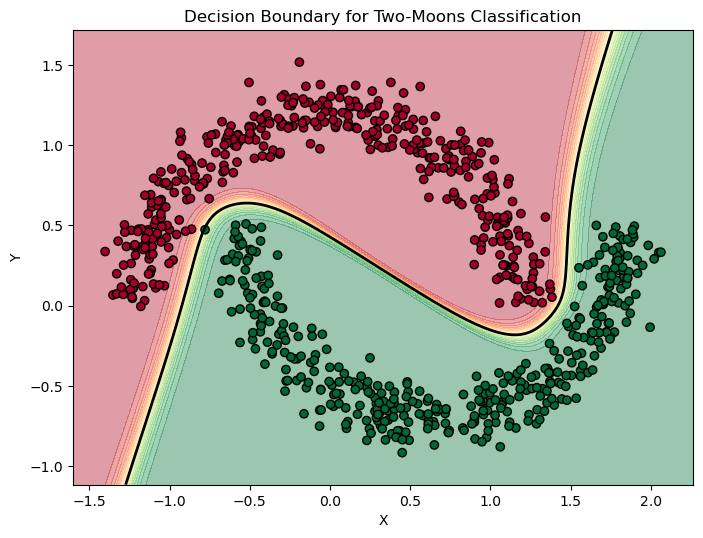

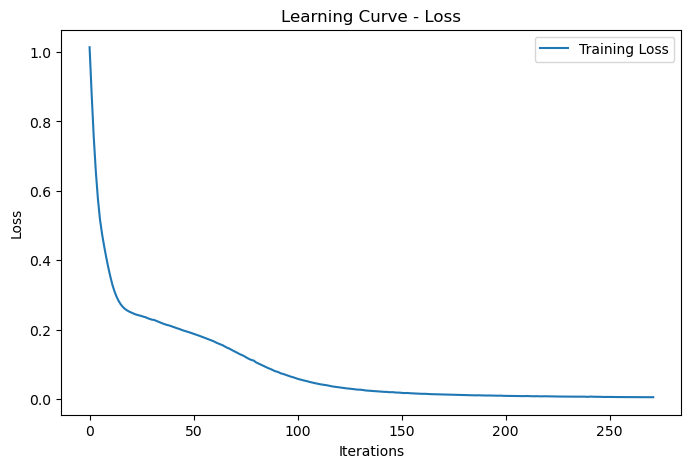


Columns in dataset: ['X', 'Y', 'ClassLabel']


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler  # <-- added for scaling

# Load dataset
# option 1: raw string (easiest)
data = pd.read_csv("2halfmoonsTrain.csv")

X = data[['X', 'Y']].values
y = (data['ClassLabel'] - 1).values  # convert class labels 1→0, 2→1

# Split data: 60% train, 20% val, 20% test  (now stratified)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# --- Scaling (fit on train only, transform all) ---
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

# Define the MLP model (unchanged)
mlp = MLPClassifier(hidden_layer_sizes=(10, 5),
                    activation='tanh',
                    solver='adam',
                    learning_rate_init=0.01,
                    max_iter=1000,
                    random_state=42)

# Train model (on scaled data)
mlp.fit(X_train_s, y_train)

# Calculate accuracies (on scaled data)
train_acc = accuracy_score(y_train, mlp.predict(X_train_s))
val_acc   = accuracy_score(y_val,   mlp.predict(X_val_s))
test_acc  = accuracy_score(y_test,  mlp.predict(X_test_s))

print(f"Training Accuracy:  {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy:      {test_acc:.4f}")

# --- 5-Fold Cross Validation (left as-is, no other changes) ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(mlp, X, y, cv=kf, scoring='accuracy')
print(f"\nCross-Validation Accuracies: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}")

# --- Decision Boundary Plot (uses predict_proba + p=0.5 contour) ---
xx, yy = np.meshgrid(
    np.linspace(X[:,0].min()-0.2, X[:,0].max()+0.2, 300),
    np.linspace(X[:,1].min()-0.2, X[:,1].max()+0.2, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]
grid_s = scaler.transform(grid)                                # scale the grid
proba = mlp.predict_proba(grid_s)[:, 1].reshape(xx.shape)      # p(class=1)
Z = (proba >= 0.5).astype(int)                                 # for background coloring

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, proba, levels=20, alpha=0.4, cmap=plt.cm.RdYlGn)  # soft background (optional)
plt.contour(xx, yy, proba, levels=[0.5], colors='k', linewidths=2)     # <-- required decision boundary
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlGn, edgecolor='k')
plt.gca().set_aspect("equal", adjustable="box")                         # keep moons round
plt.title("Decision Boundary for Two-Moons Classification")
plt.xlabel("X"); plt.ylabel("Y")

plt.show()

# --- Learning Curve Plot (unchanged) ---
plt.figure(figsize=(8,5))
plt.plot(mlp.loss_curve_, label='Training Loss')
plt.title("Learning Curve - Loss")
plt.xlabel("Iterations"); plt.ylabel("Loss")
plt.legend()
plt.show()

print("\nColumns in dataset:", data.columns.tolist())

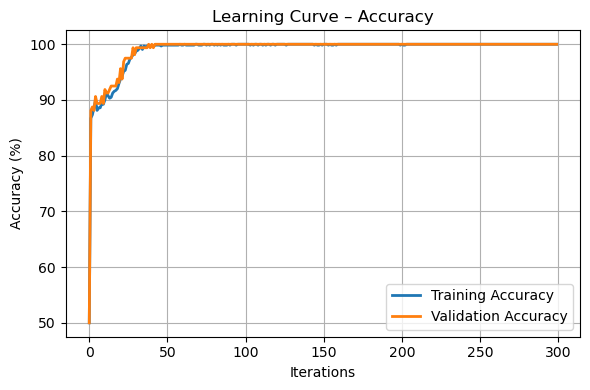

Accuracy curve saved as 'accuracy_curve_partialfit.png'


In [8]:
# ==========================================================
# Two Half Moons Classification – Accuracy Curve (Partial Fit)
# ==========================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# --- 1) Load dataset ---
df = pd.read_csv("2halfmoonsTrain.csv")  # Ensure this CSV is in the same folder
X = df[["X", "Y"]].values
y = (df["ClassLabel"].values - 1).astype(int)  # Convert {1,2} → {0,1}

# --- 2) Split into training & validation sets ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 3) Standardize inputs (train only) ---
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)

# --- 4) Define the MLP model ---
mlp = MLPClassifier(
    hidden_layer_sizes=(10, 5),
    activation="tanh",
    solver="adam",
    learning_rate_init=0.01,
    max_iter=1,          # one iteration per partial_fit step
    warm_start=True,     # continue training each loop
    random_state=42
)

# --- 5) Train using partial_fit and record accuracy ---
classes = np.array([0, 1])
epochs = 300
batch_size = 64
train_acc, val_acc = [], []

# Initialize model once
mlp.partial_fit(X_train_s[:batch_size], y_train[:batch_size], classes=classes)

for _ in range(epochs):
    # Shuffle batches each epoch
    idx = np.random.permutation(len(X_train_s))
    for start in range(0, len(X_train_s), batch_size):
        end = start + batch_size
        mlp.partial_fit(X_train_s[idx[start:end]], y_train[idx[start:end]])

    # Record accuracy (%) for this epoch
    train_acc.append(accuracy_score(y_train, mlp.predict(X_train_s)) * 100)
    val_acc.append(accuracy_score(y_val, mlp.predict(X_val_s)) * 100)

# --- 6) Plot Accuracy Curve ---
plt.figure(figsize=(6, 4))
plt.plot(train_acc, label="Training Accuracy", linewidth=2)
plt.plot(val_acc, label="Validation Accuracy", linewidth=2)
plt.xlabel("Iterations")
plt.ylabel("Accuracy (%)")
plt.title("Learning Curve – Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_curve_partialfit.png", dpi=300, bbox_inches="tight")
plt.show()

print("Accuracy curve saved as 'accuracy_curve_partialfit.png'")

In [10]:
# ===== Individual assignment: evaluate on the provided test file =====
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

test_df = pd.read_csv("2halfmoonsTest.csv")   # put the file next to the notebook
X_test_ind = test_df[["X", "Y"]].values
y_test_ind = test_df["ClassLabel"].values - 1   # 1,2 -> 0,1

# use the SAME scaler and SAME mlp from above
X_test_ind_s = scaler.transform(X_test_ind)
y_pred_ind = mlp.predict(X_test_ind_s)

cm = confusion_matrix(y_test_ind, y_pred_ind, labels=[0, 1])
cm_norm = confusion_matrix(y_test_ind, y_pred_ind, labels=[0, 1], normalize="true")
tn, fp, fn, tp = cm.ravel()

print("Confusion matrix (counts):\n", cm)
print("\nConfusion matrix (normalized):\n", cm_norm)
print(f"\nTP={tp}, FP={fp}, FN={fn}, TN={tn}")
print("Accuracy:  ", accuracy_score(y_test_ind, y_pred_ind))
print("Precision: ", precision_score(y_test_ind, y_pred_ind, zero_division=0))
print("Recall:    ", recall_score(y_test_ind, y_pred_ind, zero_division=0))
print("F1-score:  ", f1_score(y_test_ind, y_pred_ind, zero_division=0))


Confusion matrix (counts):
 [[100   0]
 [  0 100]]

Confusion matrix (normalized):
 [[1. 0.]
 [0. 1.]]

TP=100, FP=0, FN=0, TN=100
Accuracy:   1.0
Precision:  1.0
Recall:     1.0
F1-score:   1.0
